In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from src.utils_py.io.gro import read_gro, write_gro
from src.utils_py.gro.Structure import Structure
from src.utils_py.gro.Atom import Atom
from src.utils_py.geom.Box import Box
from src.utils_py.geom.AntiSphere import AntiSphere
from src.utils_py.geom.Sphere import Sphere
from src.utils_py.geom.Cylinder import Cylinder
from src.utils_py.geom.AntiCylinder import AntiCylinder
from src.utils_py.geom.CylinderSegment import CylinderSegment
from src.utils_py.geom.AntiCylinderSegment import AntiCylinderSegment
from src.utils_py.assembler.insert import insert_point_into_shape, find_position
from src.utils_py.assembler.push import push_atoms_apart
from src.utils_py.assembler.build import build_system

---

#### Конфигурация

In [2]:
folder = 'droplet_carbon_gromos'
dir_gro = 'ff/gromos/gro/'

In [3]:
HEIGHT = 6.5
WIDTH_X = 5.56
WIDTH_Y = 5.56

offset = 1
delta_h = 0.1
h = 2.337

In [4]:
''' ПАРАМЕТРЫ НЕ ТРОГАТЬ!!! '''
insertion_limit = int(1e5)
rotation_limit = 1000
package = 0.35
distance = {'min': 0.08**2, 'opt': 0.12**2}
phi = 180

system_size = np.array([WIDTH_X, WIDTH_Y, HEIGHT + h])
# structure = Structure(box=system_size, atoms=[])
structure = read_gro(f'na_diff/{folder}/car_shifted.gro')
points = list(structure.get_XYZ())
structure.box = system_size

names = ['decane', 'spce']
density = [3, 33] # nm-3
# names = ['spce']
# density = [33] # nm-3

box = Box(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h + HEIGHT/2]),
    borders=np.array([WIDTH_X, WIDTH_Y, HEIGHT])
)

box_delta = Box(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h + HEIGHT/2]),
    borders=np.array([WIDTH_X, WIDTH_Y, HEIGHT - 2 * delta_h])
)

R = (WIDTH_Y - 2 * offset) / 2 / np.sin(np.deg2rad(phi / 2))
r = (WIDTH_Y - 2 * offset) / 2 / np.tan(np.deg2rad(phi / 2))

cylinder=Cylinder(
    np.array([WIDTH_X/2, WIDTH_Y/2, h - r]), 
    radius=R, 
    length=WIDTH_X, 
    axis=np.array([1, 0, 0])
)

cylinder_segment = CylinderSegment(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h - r]), 
    cylinder=cylinder,
    segm_radius=r,
    norm=np.array([0, 0, 1])
)

cylinder_segment_delta = CylinderSegment(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h - r]), 
    cylinder=cylinder,
    segm_radius=r - delta_h,
    norm=np.array([0, 0, 1])
)

anticylinder_segment = AntiCylinderSegment(
    center=cylinder_segment.center,
    cylinder_segment=cylinder_segment,
    box=box
)

anticylinder_segment_delta = AntiCylinderSegment(
    center=cylinder_segment_delta.center,
    cylinder_segment=cylinder_segment_delta,
    box=box_delta
)

insert_shapes = [cylinder_segment_delta, anticylinder_segment_delta]
shapes = [cylinder_segment, anticylinder_segment]
# insert_shapes = [anticylinder_segment_delta]
# shapes = [anticylinder_segment]
numbers = list(np.round(np.array([shapes[i].get_volume() * density[i] for i in range(len(names))])).astype(int))

structure = build_system(
    dir_gro, structure, names, numbers, insert_shapes, points,
    insertion_limit=insertion_limit,
    rotation_limit=rotation_limit,
    package=package,
    min_dist2=distance['min']
)

Number of molecules:
decane 	 83
spce 	 5718

Filling system:


100%|██████████| 5718/5718 [02:24<00:00, 39.48it/s] 


#### Запись .gro и system.itp

In [5]:
mol_names = ''.join(map(lambda x: 'w' if x == 'spce' else x[0], names))
mol_nums = '_'.join(map(str, numbers))
filename = 'car_'+ mol_names + '_' + mol_nums

'''
#include "decane.itp"
#include "spce.itp"
#include "sil.itp"

[ system ]
test

[ molecules ]
; molecule name         nr.
#include "calmol.itp"
spce 	 1311
decane 	 2161
'''

with open(f'na_diff/{folder}/system.itp', 'w') as f:
    for name in names:
        f.write(f'#include "{name}.itp"\n')
    f.write('#include "carbon.itp"\n')

    f.write(f'\n[ system ]\n{filename}\n')
    f.write('\n[ molecules ]\n; molecule name\tnr.\n')
    f.write('#include "carmol_11.itp"\n')
    for i, name in enumerate(names):
        f.write(f'{name}\t{numbers[i]}\n')

with open(f'na_diff/{folder}/{filename}.gro', 'w') as f:
    f.write(write_gro(structure))

#### Перемешивание

In [14]:
os.system(f'./mixer -f na_diff/{folder}/{filename}.gro -o na_diff/{folder}/{filename}.gro -mn2 {distance["min"]} -opt2 {distance["opt"]}')

Iteration 1 - 1s
25 overlaps detected
Iteration 2 - 2s
1 overlaps detected
Iteration 3 - 3s
0 overlaps detected


0

#### Отправка файлов на сервер

In [44]:
files = [filename+'.gro', 'gromos.top', 'spce.itp', 'decane.itp', 'carbon.itp', 'carmol_11.itp', 'system.itp']

for file in files:
    os.system(f'scp na_diff/{folder}/{file} mipt-nd:alexey/{folder}/{file}')

---

#### Стягиваем файлы для проверки

In [45]:
os.system(f'scp mipt-nd:alexey/{folder}/{filename}.gro data/{filename}.gro')
os.system(f'scp mipt-nd:alexey/{folder}/{filename}.xtc data/{filename}.xtc')

0

#### Стягиваем файлы для рассчетов профилей плотности

In [46]:
os.system(f'scp mipt-nd:alexey/{folder}/{filename}.gro data/{filename}.gro')
os.system(f'scp mipt-nd:alexey/{folder}/{filename}.xtc data/{filename}.xtc')
os.system(f'scp mipt-nd:alexey/{folder}/{filename}.edr data/{filename}.edr')
os.system(f'scp mipt-nd:alexey/{folder}/{filename}.tpr data/{filename}.tpr')

0

---

#### Рассчет энергии

In [10]:
os.system(f'echo 10 0 | gmx energy -f data/{filename} -s data/{filename} -o data/energy')
os.system(f'rm data/#*#')


Statistics over 1000001 steps [ 0.0000 through 2000.0000 ps ], 1 data sets
All statistics are over 10001 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Total Energy               -49511.3         32    348.704   -156.418  (kJ/mol)


                  :-) GROMACS - gmx energy, 2023-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2023/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2023
Working dir:  /Users/alexey/Dev/MD_conf
Command line:
  gmx energy -f data/car_wd_913_520 -s data/car_wd_913_520 -o data/energy

Opened data/car_wd_913_520.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  G96Angle         2  Proper-Dih.      3  LJ-14            4  Coulomb-14    
  5  LJ-(SR)          6  Coulomb-(SR)     7  Coul.-recip.     8  Potential     
  9  Kinetic-En.     10  Total-Energy    11  Conserved-En.   12  Temperature   
 13  Pressure        14  Constr.-rmsd    15  Vir-XX          16  Vir-XY        
 17  Vir-XZ          18  Vir-YX          19  Vir-YY          20  Vir

0

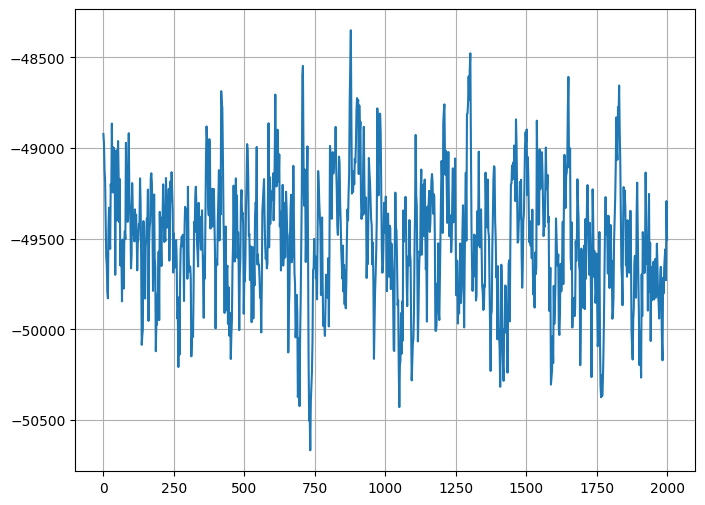

In [14]:
y, eng = np.loadtxt("data/energy.xvg",comments=["@", "#"],unpack=True)
plt.figure(figsize=(8, 6))
plt.grid()
plt.plot(y, eng)

---

#### Рассчет профиля плотности

In [44]:
os.system(f'echo 6 | gmx density -f data/{filename} -s data/{filename} -o data/density -d Z -sl 50 -dens number -ng 1 -b 500')
os.system(f'rm data/#*#')

                  :-) GROMACS - gmx density, 2023-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2023/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2023
Working dir:  /Users/alexey/Dev/MD_conf
Command line:
  gmx density -f data/car_wd_913_520 -s data/car_wd_913_520 -o data/density -d Z -sl 50 -dens number -ng 1 -b 500

Reading file data/car_wd_913_520.tpr, VERSION 2019.2 (single precision)

Select 1 group to calculate density for:
Group     0 (         System) has 14590 elements
Group     1 (          Other) has 14590 elements
Group     2 (             GR) has  6609 elements
Group     3 (            GR1) has    14 elements
Group     4 (            GRO) has    14 elements
Group     5 (            GRH) has    14 elements
Group     6 (          WATER) has  2739 elements
Group     7 (          DECAN) has  5200 elements
Reading frame    1300 time 1800.000   

Selected 6: 'WATER'


Last frame       1500 time 2000.000   

Read 1501 frames from trajectory. Calculating density

Back Off! I just backed up data/density.xvg to data/#density.xvg.1#

GROMACS reminds you: "Breaking the Law, Breaking the Law" (Judas Priest)



0

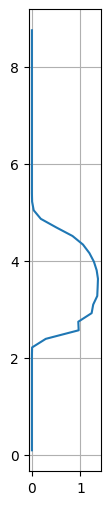

In [45]:
y, dens = np.loadtxt("data/density.xvg",comments=["@", "#"],unpack=True)
plt.figure(figsize=(8, 6))
plt.grid()
ax = plt.gca()
ax.set_aspect(1)
plt.plot(dens / 33, y)


In [36]:
structure = read_gro(f'data/car_wd_913_520.gro')
type = 'WATER'
N = 100
grid = np.zeros(N)
dr = structure.box / N

for a in structure.atoms:
    if (a.mol_name == type):
        id = np.floor(a.xyz / dr).astype(int)
        id -= (id == N)

        grid[id[0], id[1], id[2]] += 1

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

---

In [4]:
phi = 90

box = Box(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h + HEIGHT/2]),
    borders=np.array([WIDTH_X, WIDTH_Y, HEIGHT])
)

box_delta = Box(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h + HEIGHT/2]),
    borders=np.array([WIDTH_X, WIDTH_Y, HEIGHT - 2 * delta_h])
)

R = (WIDTH_Y - 2 * offset) / 2 / np.sin(np.deg2rad(phi / 2))
r = (WIDTH_Y - 2 * offset) / 2 / np.tan(np.deg2rad(phi / 2))

cylinder=Cylinder(
    np.array([WIDTH_X/2, WIDTH_Y/2, h - r]), 
    radius=R, 
    length=WIDTH_X, 
    axis=np.array([1, 0, 0])
)

cylinder_segment = CylinderSegment(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h - r]), 
    cylinder=cylinder,
    segm_radius=r,
    norm=np.array([0, 0, 1])
)

cylinder_segment_delta = CylinderSegment(
    center=np.array([WIDTH_X/2, WIDTH_Y/2, h - r]), 
    cylinder=cylinder,
    segm_radius=r - delta_h,
    norm=np.array([0, 0, 1])
)

anticylinder_segment = AntiCylinderSegment(
    center=cylinder_segment.center,
    cylinder_segment=cylinder_segment,
    box=box
)

anticylinder_segment_delta = AntiCylinderSegment(
    center=cylinder_segment_delta.center,
    cylinder_segment=cylinder_segment_delta,
    box=box_delta
)

In [9]:
print(R, r)

2.517300141024109 1.78


In [12]:
anticylinder_segment.check_point(np.array([WIDTH_X/2, WIDTH_Y/2, h+0.2]))

False

In [6]:
cylinder_segment.check_point(np.array([WIDTH_X/2, WIDTH_Y/2, h + 0.2]))

True